In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor




In [2]:
from torch.utils.data import Dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
            

    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)
        transforms = Compose([ToTensor()])
        im = transforms(im)
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types }
        return sample

In [3]:
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)


/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/malign
number of data items:73
/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/malign
number of data items:73


In [5]:
import cv2
import torch.nn as nn
import torch.nn.functional as F

z = 5 # groups
a = 15

G = np.random.randn(z, a)
W = np.random.randn(1, z)

   
def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(82944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x)
        
        y = torch.matmul(self.W_, g)
        
        return (torch.sigmoid(y), x)

model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)


criterion = torch.nn.L1Loss(reduction='sum')

criterion1 = torch.nn.L1Loss(reduction='sum')


optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

#y_tr = torch.from_numpy(y_train).to(device)
epoch = 0




In [6]:
model.load_state_dict(torch.load(f'../data/models/end_to_end_v1.pt'))

<All keys matched successfully>

In [47]:
for epoch in range(10000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)

        optimizer.zero_grad()

        (y_pred, attributes_pred) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), data["labels"][:, :15].to(device))
        
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

Epoch:  1 ; running-loss:  368.7258876580745
Epoch:  2 ; running-loss:  360.98128588683903
Epoch:  3 ; running-loss:  354.20178455207497
Epoch:  4 ; running-loss:  349.0227340525016
Epoch:  5 ; running-loss:  344.90538748074323
Epoch:  6 ; running-loss:  341.6326299495995
Epoch:  7 ; running-loss:  339.5096628824249
Epoch:  8 ; running-loss:  337.9213570486754
Epoch:  9 ; running-loss:  336.48713949508965
Epoch:  10 ; running-loss:  335.1414265902713
Epoch:  11 ; running-loss:  333.8687080703676
Epoch:  12 ; running-loss:  332.9067622292787
Epoch:  13 ; running-loss:  331.82260488532484
Epoch:  14 ; running-loss:  330.850609684363
Epoch:  15 ; running-loss:  329.85802224837244
Epoch:  16 ; running-loss:  328.794597604312
Epoch:  17 ; running-loss:  327.9223088454455
Epoch:  18 ; running-loss:  327.24716158397496
Epoch:  19 ; running-loss:  326.5399372773245
Epoch:  20 ; running-loss:  326.03573497757316
Epoch:  21 ; running-loss:  325.516928861849
Epoch:  22 ; running-loss:  325.079973

Epoch:  177 ; running-loss:  304.6319761713967
Epoch:  178 ; running-loss:  303.59490717574954
Epoch:  179 ; running-loss:  304.20825232286006
Epoch:  180 ; running-loss:  303.7581020500511
Epoch:  181 ; running-loss:  303.7559897005558
Epoch:  182 ; running-loss:  303.4296895163134
Epoch:  183 ; running-loss:  303.4235985595733
Epoch:  184 ; running-loss:  303.29256307240576
Epoch:  185 ; running-loss:  303.0124770728871
Epoch:  186 ; running-loss:  302.72156401723623
Epoch:  187 ; running-loss:  302.3480636905879
Epoch:  188 ; running-loss:  302.5529674477875
Epoch:  189 ; running-loss:  302.2224916405976
Epoch:  190 ; running-loss:  302.1967406515032
Epoch:  191 ; running-loss:  302.09747795015574
Epoch:  192 ; running-loss:  301.6540167722851
Epoch:  193 ; running-loss:  301.545722393319
Epoch:  194 ; running-loss:  301.1712588798255
Epoch:  195 ; running-loss:  300.7298781396821
Epoch:  196 ; running-loss:  301.0061574857682
Epoch:  197 ; running-loss:  300.5886025503278
Epoch:  1

Epoch:  350 ; running-loss:  291.2792125851847
Epoch:  351 ; running-loss:  292.06273711146787
Epoch:  352 ; running-loss:  291.5659629316069
Epoch:  353 ; running-loss:  291.8268487979658
Epoch:  354 ; running-loss:  291.11094862781465
Epoch:  355 ; running-loss:  291.71777881262824
Epoch:  356 ; running-loss:  291.54033771390095
Epoch:  357 ; running-loss:  291.52368771331385
Epoch:  358 ; running-loss:  291.8241401622072
Epoch:  359 ; running-loss:  292.06198684312403
Epoch:  360 ; running-loss:  291.8711414146237
Epoch:  361 ; running-loss:  291.5799872856587
Epoch:  362 ; running-loss:  290.92427855869755
Epoch:  363 ; running-loss:  290.4445843445137
Epoch:  364 ; running-loss:  290.7770451842807
Epoch:  365 ; running-loss:  291.0295103783719
Epoch:  366 ; running-loss:  290.9549910253845
Epoch:  367 ; running-loss:  290.94446824258193
Epoch:  368 ; running-loss:  291.0362604241818
Epoch:  369 ; running-loss:  291.387243966572
Epoch:  370 ; running-loss:  291.00483026215807
Epoch

Epoch:  523 ; running-loss:  288.5280588180758
Epoch:  524 ; running-loss:  288.4134087273851
Epoch:  525 ; running-loss:  287.7910650782287
Epoch:  526 ; running-loss:  288.2339483653195
Epoch:  527 ; running-loss:  287.9643699610606
Epoch:  528 ; running-loss:  288.64971074461937
Epoch:  529 ; running-loss:  287.7995205507614
Epoch:  530 ; running-loss:  288.0778560019098
Epoch:  531 ; running-loss:  287.43540693819523
Epoch:  532 ; running-loss:  288.31573911895975
Epoch:  533 ; running-loss:  288.155939492397
Epoch:  534 ; running-loss:  287.717963504605
Epoch:  535 ; running-loss:  287.92206467455253
Epoch:  536 ; running-loss:  287.4512521000579
Epoch:  537 ; running-loss:  288.3737792763859
Epoch:  538 ; running-loss:  287.99056696891785
Epoch:  539 ; running-loss:  287.68726054253057
Epoch:  540 ; running-loss:  288.4500236287713
Epoch:  541 ; running-loss:  287.6254942067899
Epoch:  542 ; running-loss:  287.65586688555777
Epoch:  543 ; running-loss:  287.87800158467144
Epoch: 

Epoch:  697 ; running-loss:  284.88338779844344
Epoch:  698 ; running-loss:  284.8225480923429
Epoch:  699 ; running-loss:  285.5672464002855
Epoch:  700 ; running-loss:  285.00202321168035
Epoch:  701 ; running-loss:  285.0598413525149
Epoch:  702 ; running-loss:  285.43529255874455
Epoch:  703 ; running-loss:  285.2055400162935
Epoch:  704 ; running-loss:  286.0023835282773
Epoch:  705 ; running-loss:  285.0256911125034
Epoch:  706 ; running-loss:  285.07559557724744
Epoch:  707 ; running-loss:  285.0063058058731
Epoch:  708 ; running-loss:  285.11778102768585
Epoch:  709 ; running-loss:  285.7759941993281
Epoch:  710 ; running-loss:  284.50988029362634
Epoch:  711 ; running-loss:  284.75727601954713
Epoch:  712 ; running-loss:  284.8199191307649
Epoch:  713 ; running-loss:  284.7360657872632
Epoch:  714 ; running-loss:  284.83074990753084
Epoch:  715 ; running-loss:  285.50809509074315
Epoch:  716 ; running-loss:  284.2857223087922
Epoch:  717 ; running-loss:  284.83389411401004
Epo

Epoch:  871 ; running-loss:  282.0805527837947
Epoch:  872 ; running-loss:  282.3793977983296
Epoch:  873 ; running-loss:  282.7099544927478
Epoch:  874 ; running-loss:  282.91851466242224
Epoch:  875 ; running-loss:  283.1920454604551
Epoch:  876 ; running-loss:  281.74212477821857
Epoch:  877 ; running-loss:  283.27169267926365
Epoch:  878 ; running-loss:  282.9822796275839
Epoch:  879 ; running-loss:  282.16378058772534
Epoch:  880 ; running-loss:  282.80114014074206
Epoch:  881 ; running-loss:  281.895740843378
Epoch:  882 ; running-loss:  282.80119454301894
Epoch:  883 ; running-loss:  283.4270674837753
Epoch:  884 ; running-loss:  282.74534429237247
Epoch:  885 ; running-loss:  282.27674797037616
Epoch:  886 ; running-loss:  281.8871042607352
Epoch:  887 ; running-loss:  282.58526097238064
Epoch:  888 ; running-loss:  282.03650627471507
Epoch:  889 ; running-loss:  282.6545570027083
Epoch:  890 ; running-loss:  283.11693872511387
Epoch:  891 ; running-loss:  282.60158638097346
Ep

Epoch:  1044 ; running-loss:  280.1549789272249
Epoch:  1045 ; running-loss:  280.2242328412831
Epoch:  1046 ; running-loss:  281.44119529798627
Epoch:  1047 ; running-loss:  280.7487674737349
Epoch:  1048 ; running-loss:  280.39503601565957
Epoch:  1049 ; running-loss:  280.55516070034355
Epoch:  1050 ; running-loss:  281.4645452750847
Epoch:  1051 ; running-loss:  280.3825553925708
Epoch:  1052 ; running-loss:  280.1235980624333
Epoch:  1053 ; running-loss:  279.74753445666283
Epoch:  1054 ; running-loss:  281.00428121723235
Epoch:  1055 ; running-loss:  280.19543637521565
Epoch:  1056 ; running-loss:  280.20378462038934
Epoch:  1057 ; running-loss:  281.27115320879966
Epoch:  1058 ; running-loss:  280.3085578242317
Epoch:  1059 ; running-loss:  280.63055185601115
Epoch:  1060 ; running-loss:  280.3012362467125
Epoch:  1061 ; running-loss:  279.2881409684196
Epoch:  1062 ; running-loss:  279.94096116442233
Epoch:  1063 ; running-loss:  279.7079883720726
Epoch:  1064 ; running-loss:  

Epoch:  1214 ; running-loss:  279.9533358179033
Epoch:  1215 ; running-loss:  278.21399842295796
Epoch:  1216 ; running-loss:  278.21528750192374
Epoch:  1217 ; running-loss:  277.9485745159909
Epoch:  1218 ; running-loss:  277.8709253957495
Epoch:  1219 ; running-loss:  276.9215279780328
Epoch:  1220 ; running-loss:  276.8532684221864
Epoch:  1221 ; running-loss:  277.21373266819865
Epoch:  1222 ; running-loss:  277.1791481813416
Epoch:  1223 ; running-loss:  276.9621692802757
Epoch:  1224 ; running-loss:  277.04052454885095
Epoch:  1225 ; running-loss:  276.69348994176835
Epoch:  1226 ; running-loss:  278.4029790330678
Epoch:  1227 ; running-loss:  277.7477221125737
Epoch:  1228 ; running-loss:  278.17904523108155
Epoch:  1229 ; running-loss:  277.52292842883617
Epoch:  1230 ; running-loss:  277.98484453279525
Epoch:  1231 ; running-loss:  278.03053363319486
Epoch:  1232 ; running-loss:  276.5734471799806
Epoch:  1233 ; running-loss:  277.387787591666
Epoch:  1234 ; running-loss:  27

Epoch:  1384 ; running-loss:  276.81311532482505
Epoch:  1385 ; running-loss:  274.8245333330706
Epoch:  1386 ; running-loss:  274.48457953333855
Epoch:  1387 ; running-loss:  273.2026644991711
Epoch:  1388 ; running-loss:  275.7769206678495
Epoch:  1389 ; running-loss:  276.62772507593036
Epoch:  1390 ; running-loss:  274.4804613953456
Epoch:  1391 ; running-loss:  275.1370309125632
Epoch:  1392 ; running-loss:  276.2958004027605
Epoch:  1393 ; running-loss:  276.1270008534193
Epoch:  1394 ; running-loss:  275.45465864799917
Epoch:  1395 ; running-loss:  274.5318053327501
Epoch:  1396 ; running-loss:  275.6370949828997
Epoch:  1397 ; running-loss:  275.6614954145625
Epoch:  1398 ; running-loss:  275.4734544074163
Epoch:  1399 ; running-loss:  274.81594121363014
Epoch:  1400 ; running-loss:  275.0513292476535
Epoch:  1401 ; running-loss:  276.13788354955614
Epoch:  1402 ; running-loss:  274.8264827122912
Epoch:  1403 ; running-loss:  274.1787856463343
Epoch:  1404 ; running-loss:  274.

Epoch:  1554 ; running-loss:  273.0204536514357
Epoch:  1555 ; running-loss:  271.05254624411464
Epoch:  1556 ; running-loss:  273.9360314710066
Epoch:  1557 ; running-loss:  270.7394123263657
Epoch:  1558 ; running-loss:  271.7716825082898
Epoch:  1559 ; running-loss:  273.0911286016926
Epoch:  1560 ; running-loss:  273.70296587608755
Epoch:  1561 ; running-loss:  272.7782262824476
Epoch:  1562 ; running-loss:  273.14712267089635
Epoch:  1563 ; running-loss:  274.30331176985055
Epoch:  1564 ; running-loss:  271.64647344034165
Epoch:  1565 ; running-loss:  272.7502093799412
Epoch:  1566 ; running-loss:  272.87847543973476
Epoch:  1567 ; running-loss:  270.44585620518774
Epoch:  1568 ; running-loss:  272.626935322769
Epoch:  1569 ; running-loss:  273.57149430550635
Epoch:  1570 ; running-loss:  271.16524645872414
Epoch:  1571 ; running-loss:  272.7964363396168
Epoch:  1572 ; running-loss:  273.37176186963916
Epoch:  1573 ; running-loss:  272.5355195933953
Epoch:  1574 ; running-loss:  2

Epoch:  1724 ; running-loss:  270.92979694064707
Epoch:  1725 ; running-loss:  268.85000706650317
Epoch:  1726 ; running-loss:  271.19805519096553
Epoch:  1727 ; running-loss:  270.42269240133464
Epoch:  1728 ; running-loss:  270.8997723115608
Epoch:  1729 ; running-loss:  269.44788465928286
Epoch:  1730 ; running-loss:  270.39148048032075
Epoch:  1731 ; running-loss:  270.38363929186016
Epoch:  1732 ; running-loss:  270.5483639743179
Epoch:  1733 ; running-loss:  271.46058528963476
Epoch:  1734 ; running-loss:  268.0502787847072
Epoch:  1735 ; running-loss:  269.0672907298431
Epoch:  1736 ; running-loss:  268.6386559251696
Epoch:  1737 ; running-loss:  268.93259369861335
Epoch:  1738 ; running-loss:  269.19555221218616
Epoch:  1739 ; running-loss:  270.5571851339191
Epoch:  1740 ; running-loss:  270.3848052099347
Epoch:  1741 ; running-loss:  269.6382174510509
Epoch:  1742 ; running-loss:  270.8593983994797
Epoch:  1743 ; running-loss:  269.2283495888114
Epoch:  1744 ; running-loss:  

Epoch:  1894 ; running-loss:  265.38540124055
Epoch:  1895 ; running-loss:  269.06507185287774
Epoch:  1896 ; running-loss:  267.62537332624197
Epoch:  1897 ; running-loss:  267.65427129808813
Epoch:  1898 ; running-loss:  265.79653965495527
Epoch:  1899 ; running-loss:  266.14941588323563
Epoch:  1900 ; running-loss:  268.79383586440235
Epoch:  1901 ; running-loss:  267.49744153395295
Epoch:  1902 ; running-loss:  266.56339637655765
Epoch:  1903 ; running-loss:  264.6914993207902
Epoch:  1904 ; running-loss:  265.8410419235006
Epoch:  1905 ; running-loss:  267.486834875308
Epoch:  1906 ; running-loss:  268.46774404495955
Epoch:  1907 ; running-loss:  267.51585911680013
Epoch:  1908 ; running-loss:  266.3183786999434
Epoch:  1909 ; running-loss:  267.81688525993377
Epoch:  1910 ; running-loss:  266.0339162983
Epoch:  1911 ; running-loss:  268.1245769057423
Epoch:  1912 ; running-loss:  266.3265537209809
Epoch:  1913 ; running-loss:  270.22050302568823
Epoch:  1914 ; running-loss:  265.

Epoch:  2064 ; running-loss:  263.02201531268656
Epoch:  2065 ; running-loss:  265.8148254705593
Epoch:  2066 ; running-loss:  265.8641878059134
Epoch:  2067 ; running-loss:  264.2477151751518
Epoch:  2068 ; running-loss:  263.3677701121196
Epoch:  2069 ; running-loss:  263.7305671945214
Epoch:  2070 ; running-loss:  265.2108799777925
Epoch:  2071 ; running-loss:  266.5819152658805
Epoch:  2072 ; running-loss:  264.1956295464188
Epoch:  2073 ; running-loss:  264.40126219484955
Epoch:  2074 ; running-loss:  263.86809624824673
Epoch:  2075 ; running-loss:  264.4499814771116
Epoch:  2076 ; running-loss:  264.5681381961331
Epoch:  2077 ; running-loss:  265.0489201657474
Epoch:  2078 ; running-loss:  264.51001709792763
Epoch:  2079 ; running-loss:  263.90364608634263
Epoch:  2080 ; running-loss:  268.7791705913842
Epoch:  2081 ; running-loss:  264.1990935849026
Epoch:  2082 ; running-loss:  264.9343709638342
Epoch:  2083 ; running-loss:  264.3590455399826
Epoch:  2084 ; running-loss:  265.5

Epoch:  2234 ; running-loss:  265.0401833029464
Epoch:  2235 ; running-loss:  261.9760359013453
Epoch:  2236 ; running-loss:  265.0126396175474
Epoch:  2237 ; running-loss:  262.0511682862416
Epoch:  2238 ; running-loss:  260.80044356919825
Epoch:  2239 ; running-loss:  262.0244713500142
Epoch:  2240 ; running-loss:  263.743042152375
Epoch:  2241 ; running-loss:  262.38414353039116
Epoch:  2242 ; running-loss:  263.58327155560255
Epoch:  2243 ; running-loss:  263.7211137339473
Epoch:  2244 ; running-loss:  265.9125068709254
Epoch:  2245 ; running-loss:  261.9679034240544
Epoch:  2246 ; running-loss:  264.9983671028167
Epoch:  2247 ; running-loss:  262.1049786452204
Epoch:  2248 ; running-loss:  261.2813468147069
Epoch:  2249 ; running-loss:  264.5257672909647
Epoch:  2250 ; running-loss:  263.3889530906454
Epoch:  2251 ; running-loss:  262.83373641595244
Epoch:  2252 ; running-loss:  262.2966167097911
Epoch:  2253 ; running-loss:  265.6861877180636
Epoch:  2254 ; running-loss:  262.487

Epoch:  2404 ; running-loss:  259.76420716941357
Epoch:  2405 ; running-loss:  261.6542875915766
Epoch:  2406 ; running-loss:  260.07455616723746
Epoch:  2407 ; running-loss:  261.6696250811219
Epoch:  2408 ; running-loss:  260.464458049275
Epoch:  2409 ; running-loss:  259.14403944741935
Epoch:  2410 ; running-loss:  258.6709453035146
Epoch:  2411 ; running-loss:  258.81616427283734
Epoch:  2412 ; running-loss:  258.77119472436607
Epoch:  2413 ; running-loss:  260.8423172822222
Epoch:  2414 ; running-loss:  258.8348630759865
Epoch:  2415 ; running-loss:  258.11918544676155
Epoch:  2416 ; running-loss:  262.14928753022105
Epoch:  2417 ; running-loss:  259.6751968776807
Epoch:  2418 ; running-loss:  256.78021986596286
Epoch:  2419 ; running-loss:  259.6131347147748
Epoch:  2420 ; running-loss:  260.48195520043373
Epoch:  2421 ; running-loss:  258.95242806803435
Epoch:  2422 ; running-loss:  258.7399182198569
Epoch:  2423 ; running-loss:  259.99699751473963
Epoch:  2424 ; running-loss:  

Epoch:  2574 ; running-loss:  257.6448460454121
Epoch:  2575 ; running-loss:  260.09224712476134
Epoch:  2576 ; running-loss:  258.7126584658399
Epoch:  2577 ; running-loss:  256.6522170910612
Epoch:  2578 ; running-loss:  258.1711587822065
Epoch:  2579 ; running-loss:  257.0327397985384
Epoch:  2580 ; running-loss:  258.1976537266746
Epoch:  2581 ; running-loss:  259.0105511015281
Epoch:  2582 ; running-loss:  257.46050057467073
Epoch:  2583 ; running-loss:  257.6459066243842
Epoch:  2584 ; running-loss:  257.60031175240874
Epoch:  2585 ; running-loss:  255.7716502835974
Epoch:  2586 ; running-loss:  256.13094257283956
Epoch:  2587 ; running-loss:  254.99271631520241
Epoch:  2588 ; running-loss:  256.3118227329105
Epoch:  2589 ; running-loss:  257.76097585167736
Epoch:  2590 ; running-loss:  255.0819666320458
Epoch:  2591 ; running-loss:  260.649441040121
Epoch:  2592 ; running-loss:  257.53394547104836
Epoch:  2593 ; running-loss:  254.49191062245518
Epoch:  2594 ; running-loss:  256

Epoch:  2743 ; running-loss:  253.22120991814882
Epoch:  2744 ; running-loss:  256.63691723532975
Epoch:  2745 ; running-loss:  252.4257144164294
Epoch:  2746 ; running-loss:  254.35922989342362
Epoch:  2747 ; running-loss:  255.6577483806759
Epoch:  2748 ; running-loss:  255.6978993229568
Epoch:  2749 ; running-loss:  253.3678356288001
Epoch:  2750 ; running-loss:  254.9735625097528
Epoch:  2751 ; running-loss:  252.32488497998565
Epoch:  2752 ; running-loss:  255.32325492519885
Epoch:  2753 ; running-loss:  256.440722479485
Epoch:  2754 ; running-loss:  255.52056717313826
Epoch:  2755 ; running-loss:  254.66073388420045
Epoch:  2756 ; running-loss:  255.3357260832563
Epoch:  2757 ; running-loss:  254.19616265501827
Epoch:  2758 ; running-loss:  253.48640990443528
Epoch:  2759 ; running-loss:  256.76974985934794
Epoch:  2760 ; running-loss:  252.16219642199576
Epoch:  2761 ; running-loss:  253.00521054305136
Epoch:  2762 ; running-loss:  254.33707331120968
Epoch:  2763 ; running-loss:

Epoch:  2912 ; running-loss:  253.72655008733273
Epoch:  2913 ; running-loss:  251.3327087946236
Epoch:  2914 ; running-loss:  253.51320988498628
Epoch:  2915 ; running-loss:  251.91908080130816
Epoch:  2916 ; running-loss:  251.39403400104493
Epoch:  2917 ; running-loss:  251.70378824323416
Epoch:  2918 ; running-loss:  250.7746727326885
Epoch:  2919 ; running-loss:  252.81797409337014
Epoch:  2920 ; running-loss:  253.23542089015245
Epoch:  2921 ; running-loss:  251.6690078889951
Epoch:  2922 ; running-loss:  251.98812115658075
Epoch:  2923 ; running-loss:  249.79924832563847
Epoch:  2924 ; running-loss:  252.86497574020177
Epoch:  2925 ; running-loss:  253.34436977934092
Epoch:  2926 ; running-loss:  253.20753706153482
Epoch:  2927 ; running-loss:  250.58075950015336
Epoch:  2928 ; running-loss:  250.76537837088108
Epoch:  2929 ; running-loss:  251.55584406200796
Epoch:  2930 ; running-loss:  253.55315847788006
Epoch:  2931 ; running-loss:  252.9593764655292
Epoch:  2932 ; running-l

Epoch:  3081 ; running-loss:  248.14130996912718
Epoch:  3082 ; running-loss:  248.88035742752254
Epoch:  3083 ; running-loss:  250.0433997111395
Epoch:  3084 ; running-loss:  248.98806592728943
Epoch:  3085 ; running-loss:  247.61944679357111
Epoch:  3086 ; running-loss:  247.74004845879972
Epoch:  3087 ; running-loss:  249.79518607538193
Epoch:  3088 ; running-loss:  246.87732454482466
Epoch:  3089 ; running-loss:  250.60655559692532
Epoch:  3090 ; running-loss:  248.43557730689645
Epoch:  3091 ; running-loss:  248.52830323576927
Epoch:  3092 ; running-loss:  245.88235209230334
Epoch:  3093 ; running-loss:  251.4467985453084
Epoch:  3094 ; running-loss:  250.30048121884465
Epoch:  3095 ; running-loss:  250.07140263728797
Epoch:  3096 ; running-loss:  248.65275720413774
Epoch:  3097 ; running-loss:  249.77884230203927
Epoch:  3098 ; running-loss:  245.51434630528092
Epoch:  3099 ; running-loss:  247.79134866409004
Epoch:  3100 ; running-loss:  249.08219236135483
Epoch:  3101 ; running

Epoch:  3250 ; running-loss:  244.65547615662217
Epoch:  3251 ; running-loss:  245.0100016715005
Epoch:  3252 ; running-loss:  248.5897080898285
Epoch:  3253 ; running-loss:  247.01745814364403
Epoch:  3254 ; running-loss:  244.61906826496124
Epoch:  3255 ; running-loss:  245.21307058259845
Epoch:  3256 ; running-loss:  245.00342073198408
Epoch:  3257 ; running-loss:  248.86024016607553
Epoch:  3258 ; running-loss:  245.81692965049297
Epoch:  3259 ; running-loss:  249.62748216558248
Epoch:  3260 ; running-loss:  246.332944881171
Epoch:  3261 ; running-loss:  250.0684997010976
Epoch:  3262 ; running-loss:  249.04304743278772
Epoch:  3263 ; running-loss:  245.4588477369398
Epoch:  3264 ; running-loss:  247.82019961625338
Epoch:  3265 ; running-loss:  244.70434223581105
Epoch:  3266 ; running-loss:  244.49094621744007
Epoch:  3267 ; running-loss:  246.2555683925748
Epoch:  3268 ; running-loss:  244.83063540048897
Epoch:  3269 ; running-loss:  246.3078330429271
Epoch:  3270 ; running-loss:

Epoch:  3419 ; running-loss:  243.95683093834668
Epoch:  3420 ; running-loss:  244.78972280863672
Epoch:  3421 ; running-loss:  241.8414126643911
Epoch:  3422 ; running-loss:  243.76777830906212
Epoch:  3423 ; running-loss:  242.00851901154965
Epoch:  3424 ; running-loss:  242.9915520157665
Epoch:  3425 ; running-loss:  247.0030767498538
Epoch:  3426 ; running-loss:  242.47946179285645
Epoch:  3427 ; running-loss:  243.8496596366167
Epoch:  3428 ; running-loss:  242.79423674475402
Epoch:  3429 ; running-loss:  244.57575076632202
Epoch:  3430 ; running-loss:  242.1059929933399
Epoch:  3431 ; running-loss:  245.01707957591861
Epoch:  3432 ; running-loss:  242.72763921134174
Epoch:  3433 ; running-loss:  244.20177167560905
Epoch:  3434 ; running-loss:  243.64020693395287
Epoch:  3435 ; running-loss:  243.60204850882292
Epoch:  3436 ; running-loss:  247.28963674698025
Epoch:  3437 ; running-loss:  242.32002942450345
Epoch:  3438 ; running-loss:  243.76772222016007
Epoch:  3439 ; running-lo

Epoch:  3588 ; running-loss:  241.72302628401667
Epoch:  3589 ; running-loss:  241.2353303898126
Epoch:  3590 ; running-loss:  240.9466915447265
Epoch:  3591 ; running-loss:  238.81703347247094
Epoch:  3592 ; running-loss:  241.39047811273485
Epoch:  3593 ; running-loss:  244.18929031211883
Epoch:  3594 ; running-loss:  235.80589539557695
Epoch:  3595 ; running-loss:  244.44252806529403
Epoch:  3596 ; running-loss:  243.81495441496372
Epoch:  3597 ; running-loss:  241.04787817876786
Epoch:  3598 ; running-loss:  241.893501682207
Epoch:  3599 ; running-loss:  241.87376726511866
Epoch:  3600 ; running-loss:  242.14289412181824
Epoch:  3601 ; running-loss:  238.72367307171226
Epoch:  3602 ; running-loss:  240.80223216488957
Epoch:  3603 ; running-loss:  236.946553892456
Epoch:  3604 ; running-loss:  239.939170435071
Epoch:  3605 ; running-loss:  244.03795130364597
Epoch:  3606 ; running-loss:  238.9276794102043
Epoch:  3607 ; running-loss:  239.40479335188866
Epoch:  3608 ; running-loss: 

Epoch:  3757 ; running-loss:  238.45895178429782
Epoch:  3758 ; running-loss:  240.14323544036597
Epoch:  3759 ; running-loss:  237.6211808240041
Epoch:  3760 ; running-loss:  238.06033353321254
Epoch:  3761 ; running-loss:  236.8592356648296
Epoch:  3762 ; running-loss:  238.3033554488793
Epoch:  3763 ; running-loss:  239.88340660370886
Epoch:  3764 ; running-loss:  238.86218571849167
Epoch:  3765 ; running-loss:  239.8488272568211
Epoch:  3766 ; running-loss:  237.01728235557675
Epoch:  3767 ; running-loss:  237.05113690719008
Epoch:  3768 ; running-loss:  240.0268805352971
Epoch:  3769 ; running-loss:  239.36183564271778
Epoch:  3770 ; running-loss:  238.67369218263775
Epoch:  3771 ; running-loss:  241.43293934501708
Epoch:  3772 ; running-loss:  236.7521174615249
Epoch:  3773 ; running-loss:  237.14813014864922
Epoch:  3774 ; running-loss:  237.37561831716448
Epoch:  3775 ; running-loss:  235.93165196385235
Epoch:  3776 ; running-loss:  242.2565433131531
Epoch:  3777 ; running-loss

Epoch:  3926 ; running-loss:  234.9470821423456
Epoch:  3927 ; running-loss:  235.36553529184312
Epoch:  3928 ; running-loss:  237.572660041973
Epoch:  3929 ; running-loss:  237.2476628255099
Epoch:  3930 ; running-loss:  237.139083430171
Epoch:  3931 ; running-loss:  232.54165598843247
Epoch:  3932 ; running-loss:  234.11560891475528
Epoch:  3933 ; running-loss:  233.7020904822275
Epoch:  3934 ; running-loss:  236.35556364338845
Epoch:  3935 ; running-loss:  234.63299250323325
Epoch:  3936 ; running-loss:  235.83213875070214
Epoch:  3937 ; running-loss:  234.50575596932322
Epoch:  3938 ; running-loss:  237.2918033367023
Epoch:  3939 ; running-loss:  235.52936422545463
Epoch:  3940 ; running-loss:  232.97919828724116
Epoch:  3941 ; running-loss:  233.94768455438316
Epoch:  3942 ; running-loss:  233.17098446190357
Epoch:  3943 ; running-loss:  240.8789063161239
Epoch:  3944 ; running-loss:  231.60333954263479
Epoch:  3945 ; running-loss:  233.62817125674337
Epoch:  3946 ; running-loss: 

Epoch:  4095 ; running-loss:  232.03523249272257
Epoch:  4096 ; running-loss:  237.80894729401916
Epoch:  4097 ; running-loss:  233.68985133990645
Epoch:  4098 ; running-loss:  230.9833957850933
Epoch:  4099 ; running-loss:  230.26587558630854
Epoch:  4100 ; running-loss:  232.38630799297243
Epoch:  4101 ; running-loss:  234.35481976438314
Epoch:  4102 ; running-loss:  236.27577286958694
Epoch:  4103 ; running-loss:  229.319379478693
Epoch:  4104 ; running-loss:  231.39059218484908
Epoch:  4105 ; running-loss:  232.58906160853803
Epoch:  4106 ; running-loss:  230.03607426397502
Epoch:  4107 ; running-loss:  234.03653770685196
Epoch:  4108 ; running-loss:  229.42748187109828
Epoch:  4109 ; running-loss:  230.80258650891483
Epoch:  4110 ; running-loss:  235.07997837569565
Epoch:  4111 ; running-loss:  229.64298874139786
Epoch:  4112 ; running-loss:  230.27429465856403
Epoch:  4113 ; running-loss:  236.0618319492787
Epoch:  4114 ; running-loss:  230.5688278125599
Epoch:  4115 ; running-lo

Epoch:  4264 ; running-loss:  229.48721229843795
Epoch:  4265 ; running-loss:  232.2571430373937
Epoch:  4266 ; running-loss:  230.9204464480281
Epoch:  4267 ; running-loss:  229.13098801486194
Epoch:  4268 ; running-loss:  227.6639572577551
Epoch:  4269 ; running-loss:  229.55664538498968
Epoch:  4270 ; running-loss:  232.50385522190481
Epoch:  4271 ; running-loss:  229.73180528078228
Epoch:  4272 ; running-loss:  228.0740649290383
Epoch:  4273 ; running-loss:  227.96229487657547
Epoch:  4274 ; running-loss:  231.02426977455616
Epoch:  4275 ; running-loss:  233.07568607851863
Epoch:  4276 ; running-loss:  228.9010258866474
Epoch:  4277 ; running-loss:  229.42724867351353
Epoch:  4278 ; running-loss:  225.84855762217194
Epoch:  4279 ; running-loss:  226.57430062815547
Epoch:  4280 ; running-loss:  233.57759566418827
Epoch:  4281 ; running-loss:  229.5548939537257
Epoch:  4282 ; running-loss:  229.89759829081595
Epoch:  4283 ; running-loss:  227.8203777037561
Epoch:  4284 ; running-loss

Epoch:  4433 ; running-loss:  230.02174803055823
Epoch:  4434 ; running-loss:  229.63362844195217
Epoch:  4435 ; running-loss:  226.12655151356012
Epoch:  4436 ; running-loss:  228.47855657339096
Epoch:  4437 ; running-loss:  227.38839207217097
Epoch:  4438 ; running-loss:  226.54633390065283
Epoch:  4439 ; running-loss:  228.7321971701458
Epoch:  4440 ; running-loss:  229.19732592999935
Epoch:  4441 ; running-loss:  225.92308419384062
Epoch:  4442 ; running-loss:  226.01355499215424
Epoch:  4443 ; running-loss:  226.66362198069692
Epoch:  4444 ; running-loss:  227.01406119484454
Epoch:  4445 ; running-loss:  226.81993328034878
Epoch:  4446 ; running-loss:  222.8839296316728
Epoch:  4447 ; running-loss:  226.84507901780307
Epoch:  4448 ; running-loss:  228.0062578227371
Epoch:  4449 ; running-loss:  224.31318882200867
Epoch:  4450 ; running-loss:  224.48541881795973
Epoch:  4451 ; running-loss:  226.9693401772529
Epoch:  4452 ; running-loss:  227.81925999186933
Epoch:  4453 ; running-l

Epoch:  4602 ; running-loss:  225.2018423518166
Epoch:  4603 ; running-loss:  220.621189808473
Epoch:  4604 ; running-loss:  226.87227818369865
Epoch:  4605 ; running-loss:  214.72526371572167
Epoch:  4606 ; running-loss:  227.7708774972707
Epoch:  4607 ; running-loss:  227.9660486560315
Epoch:  4608 ; running-loss:  222.64821396302432
Epoch:  4609 ; running-loss:  226.00035385228693
Epoch:  4610 ; running-loss:  221.88170531578362
Epoch:  4611 ; running-loss:  222.9077153308317
Epoch:  4612 ; running-loss:  225.19831843301654
Epoch:  4613 ; running-loss:  222.14799471572042
Epoch:  4614 ; running-loss:  227.16534081101418
Epoch:  4615 ; running-loss:  222.85777737852186
Epoch:  4616 ; running-loss:  225.60608695540577
Epoch:  4617 ; running-loss:  223.42608029209077
Epoch:  4618 ; running-loss:  227.12161998450756
Epoch:  4619 ; running-loss:  228.3842199333012
Epoch:  4620 ; running-loss:  219.94226588029414
Epoch:  4621 ; running-loss:  220.10940862167627
Epoch:  4622 ; running-loss

Epoch:  4771 ; running-loss:  226.31767307408154
Epoch:  4772 ; running-loss:  220.74742479249835
Epoch:  4773 ; running-loss:  218.5567280864343
Epoch:  4774 ; running-loss:  218.6462882468477
Epoch:  4775 ; running-loss:  225.8790774391964
Epoch:  4776 ; running-loss:  226.5558384777978
Epoch:  4777 ; running-loss:  224.19143868330866
Epoch:  4778 ; running-loss:  227.6780871571973
Epoch:  4779 ; running-loss:  221.41213339567184
Epoch:  4780 ; running-loss:  224.9760948335752
Epoch:  4781 ; running-loss:  223.26810882985592
Epoch:  4782 ; running-loss:  224.21507604699582
Epoch:  4783 ; running-loss:  220.2254048306495
Epoch:  4784 ; running-loss:  222.88421318866313
Epoch:  4785 ; running-loss:  218.08885435480624
Epoch:  4786 ; running-loss:  224.04933494329453
Epoch:  4787 ; running-loss:  217.44521398935467
Epoch:  4788 ; running-loss:  219.79574610572308
Epoch:  4789 ; running-loss:  226.61722748633474
Epoch:  4790 ; running-loss:  215.68293035402894
Epoch:  4791 ; running-loss

Epoch:  4940 ; running-loss:  217.8034304669127
Epoch:  4941 ; running-loss:  219.67888249270618
Epoch:  4942 ; running-loss:  217.5736546618864
Epoch:  4943 ; running-loss:  216.70009285211563
Epoch:  4944 ; running-loss:  215.34907346311957
Epoch:  4945 ; running-loss:  220.73118721228093
Epoch:  4946 ; running-loss:  215.12835960369557
Epoch:  4947 ; running-loss:  216.89118972420692
Epoch:  4948 ; running-loss:  225.11115281283855
Epoch:  4949 ; running-loss:  218.85257727932185
Epoch:  4950 ; running-loss:  213.77246579248458
Epoch:  4951 ; running-loss:  218.91396343708038
Epoch:  4952 ; running-loss:  218.21328855119646
Epoch:  4953 ; running-loss:  218.74780013319105
Epoch:  4954 ; running-loss:  214.3566758884117
Epoch:  4955 ; running-loss:  222.30414299108088
Epoch:  4956 ; running-loss:  216.02082570269704
Epoch:  4957 ; running-loss:  218.4703864241019
Epoch:  4958 ; running-loss:  217.7415766492486
Epoch:  4959 ; running-loss:  211.204978633672
Epoch:  4960 ; running-loss

Epoch:  5109 ; running-loss:  213.05710995942354
Epoch:  5110 ; running-loss:  219.94440027792007
Epoch:  5111 ; running-loss:  216.66111905220896
Epoch:  5112 ; running-loss:  219.67142232693732
Epoch:  5113 ; running-loss:  218.30331401340663
Epoch:  5114 ; running-loss:  216.91997846215963
Epoch:  5115 ; running-loss:  220.12765413243324
Epoch:  5116 ; running-loss:  217.7097321236506
Epoch:  5117 ; running-loss:  213.4337120698765
Epoch:  5118 ; running-loss:  215.85614734515548
Epoch:  5119 ; running-loss:  217.83710763882846
Epoch:  5120 ; running-loss:  215.33837389480323
Epoch:  5121 ; running-loss:  217.19547496084124
Epoch:  5122 ; running-loss:  217.70995375420898
Epoch:  5123 ; running-loss:  212.3536952501163
Epoch:  5124 ; running-loss:  214.9518001275137
Epoch:  5125 ; running-loss:  214.77089520916343
Epoch:  5126 ; running-loss:  214.71004703175277
Epoch:  5127 ; running-loss:  215.6178502831608
Epoch:  5128 ; running-loss:  213.89294982980937
Epoch:  5129 ; running-lo

Epoch:  5278 ; running-loss:  213.72653731144965
Epoch:  5279 ; running-loss:  213.58868169877678
Epoch:  5280 ; running-loss:  214.595616934821
Epoch:  5281 ; running-loss:  213.22012219019234
Epoch:  5282 ; running-loss:  211.93693407438695
Epoch:  5283 ; running-loss:  210.19777317903936
Epoch:  5284 ; running-loss:  213.5928570460528
Epoch:  5285 ; running-loss:  215.90098683908582
Epoch:  5286 ; running-loss:  213.25280038360506
Epoch:  5287 ; running-loss:  213.0900778742507
Epoch:  5288 ; running-loss:  215.7974826991558
Epoch:  5289 ; running-loss:  212.64747420232743
Epoch:  5290 ; running-loss:  211.93502171896398
Epoch:  5291 ; running-loss:  210.90519298333675
Epoch:  5292 ; running-loss:  218.40086975693703
Epoch:  5293 ; running-loss:  219.8608912276104
Epoch:  5294 ; running-loss:  207.55199224874377
Epoch:  5295 ; running-loss:  214.57638410758227
Epoch:  5296 ; running-loss:  214.2413094677031
Epoch:  5297 ; running-loss:  214.04898934811354
Epoch:  5298 ; running-loss

Epoch:  5447 ; running-loss:  213.13185858074576
Epoch:  5448 ; running-loss:  211.54819215741009
Epoch:  5449 ; running-loss:  204.97813832294196
Epoch:  5450 ; running-loss:  210.55101857800037
Epoch:  5451 ; running-loss:  210.33994206413627
Epoch:  5452 ; running-loss:  207.32205450348556
Epoch:  5453 ; running-loss:  213.08664356265217
Epoch:  5454 ; running-loss:  209.96597352903336
Epoch:  5455 ; running-loss:  210.69673585053533
Epoch:  5456 ; running-loss:  212.1540696248412
Epoch:  5457 ; running-loss:  215.1031196480617
Epoch:  5458 ; running-loss:  214.2726551545784
Epoch:  5459 ; running-loss:  213.10527009610087
Epoch:  5460 ; running-loss:  207.90948153752834
Epoch:  5461 ; running-loss:  208.63086109049618
Epoch:  5462 ; running-loss:  219.22743821237236
Epoch:  5463 ; running-loss:  204.87149728182703
Epoch:  5464 ; running-loss:  214.3829965852201
Epoch:  5465 ; running-loss:  215.5787897510454
Epoch:  5466 ; running-loss:  208.56843528989702
Epoch:  5467 ; running-lo

Epoch:  5616 ; running-loss:  209.40929342713207
Epoch:  5617 ; running-loss:  204.50728925596923
Epoch:  5618 ; running-loss:  214.89369295630604
Epoch:  5619 ; running-loss:  208.75461707729846
Epoch:  5620 ; running-loss:  213.17455574590713
Epoch:  5621 ; running-loss:  208.19869846478105
Epoch:  5622 ; running-loss:  207.9190464746207
Epoch:  5623 ; running-loss:  209.43376152496785
Epoch:  5624 ; running-loss:  208.78167570196092
Epoch:  5625 ; running-loss:  206.3735271319747
Epoch:  5626 ; running-loss:  205.9724025707692
Epoch:  5627 ; running-loss:  207.5143653973937
Epoch:  5628 ; running-loss:  207.91384963318706
Epoch:  5629 ; running-loss:  214.9297520024702
Epoch:  5630 ; running-loss:  203.33635467663407
Epoch:  5631 ; running-loss:  210.54568588826805
Epoch:  5632 ; running-loss:  207.85815021861345
Epoch:  5633 ; running-loss:  207.52926357463002
Epoch:  5634 ; running-loss:  206.6041101962328
Epoch:  5635 ; running-loss:  208.35656570922583
Epoch:  5636 ; running-los

Epoch:  5785 ; running-loss:  202.98958944249898
Epoch:  5786 ; running-loss:  205.87995905429125
Epoch:  5787 ; running-loss:  202.41643625032157
Epoch:  5788 ; running-loss:  201.89191060792655
Epoch:  5789 ; running-loss:  203.9077870119363
Epoch:  5790 ; running-loss:  208.87090005725622
Epoch:  5791 ; running-loss:  204.64119157008827
Epoch:  5792 ; running-loss:  204.38403436169028
Epoch:  5793 ; running-loss:  209.57878759596497
Epoch:  5794 ; running-loss:  206.3221165947616
Epoch:  5795 ; running-loss:  207.6029186109081
Epoch:  5796 ; running-loss:  205.0445985533297
Epoch:  5797 ; running-loss:  208.55760596320033
Epoch:  5798 ; running-loss:  207.73498048819602
Epoch:  5799 ; running-loss:  208.0175967058167
Epoch:  5800 ; running-loss:  205.7518529081717
Epoch:  5801 ; running-loss:  201.89500246290118
Epoch:  5802 ; running-loss:  208.88432854320854
Epoch:  5803 ; running-loss:  198.69973906688392
Epoch:  5804 ; running-loss:  203.3232826543972
Epoch:  5805 ; running-loss

Epoch:  5954 ; running-loss:  205.48804462794214
Epoch:  5955 ; running-loss:  199.06096275150776
Epoch:  5956 ; running-loss:  204.8935051402077
Epoch:  5957 ; running-loss:  210.68901011813432
Epoch:  5958 ; running-loss:  210.88500640448183
Epoch:  5959 ; running-loss:  203.27944948058575
Epoch:  5960 ; running-loss:  203.02684587053955
Epoch:  5961 ; running-loss:  204.72442859318107
Epoch:  5962 ; running-loss:  207.77733413130045
Epoch:  5963 ; running-loss:  201.59835071582347
Epoch:  5964 ; running-loss:  197.17780285328627
Epoch:  5965 ; running-loss:  207.28501564450562
Epoch:  5966 ; running-loss:  208.61662676930428
Epoch:  5967 ; running-loss:  209.25603666342795
Epoch:  5968 ; running-loss:  206.14356573391706
Epoch:  5969 ; running-loss:  203.31894226931036
Epoch:  5970 ; running-loss:  204.1502155000344
Epoch:  5971 ; running-loss:  202.44908936414868
Epoch:  5972 ; running-loss:  201.46444194205105
Epoch:  5973 ; running-loss:  205.75568637717515
Epoch:  5974 ; running

Epoch:  6123 ; running-loss:  202.3897889861837
Epoch:  6124 ; running-loss:  205.7354595689103
Epoch:  6125 ; running-loss:  196.68123823869973
Epoch:  6126 ; running-loss:  200.92408919055015
Epoch:  6127 ; running-loss:  201.74126176070422
Epoch:  6128 ; running-loss:  200.25228589214385
Epoch:  6129 ; running-loss:  197.27848383877426
Epoch:  6130 ; running-loss:  199.13535335101187
Epoch:  6131 ; running-loss:  202.18229963537306
Epoch:  6132 ; running-loss:  194.0582572473213
Epoch:  6133 ; running-loss:  199.30129607673734
Epoch:  6134 ; running-loss:  203.11436105705798
Epoch:  6135 ; running-loss:  197.1218094965443
Epoch:  6136 ; running-loss:  203.71499376744032
Epoch:  6137 ; running-loss:  200.81567426398396
Epoch:  6138 ; running-loss:  199.40880370605737
Epoch:  6139 ; running-loss:  199.09124089125544
Epoch:  6140 ; running-loss:  201.2344811214134
Epoch:  6141 ; running-loss:  196.2883971594274
Epoch:  6142 ; running-loss:  208.14609458390623
Epoch:  6143 ; running-los

Epoch:  6292 ; running-loss:  197.7565974034369
Epoch:  6293 ; running-loss:  198.91026093252003
Epoch:  6294 ; running-loss:  201.82241692300886
Epoch:  6295 ; running-loss:  195.3265843084082
Epoch:  6296 ; running-loss:  198.4683179454878
Epoch:  6297 ; running-loss:  202.12855688575655
Epoch:  6298 ; running-loss:  200.2108563752845
Epoch:  6299 ; running-loss:  199.67995894886553
Epoch:  6300 ; running-loss:  199.7706550611183
Epoch:  6301 ; running-loss:  203.42064115591347
Epoch:  6302 ; running-loss:  194.84473935421556
Epoch:  6303 ; running-loss:  193.74447321053594
Epoch:  6304 ; running-loss:  197.66669993847609
Epoch:  6305 ; running-loss:  199.4677040465176
Epoch:  6306 ; running-loss:  204.54058110155165
Epoch:  6307 ; running-loss:  193.41092880629003
Epoch:  6308 ; running-loss:  197.33777308370918
Epoch:  6309 ; running-loss:  199.99771184194833
Epoch:  6310 ; running-loss:  201.05306623969227
Epoch:  6311 ; running-loss:  197.57437163498253
Epoch:  6312 ; running-los

Epoch:  6461 ; running-loss:  190.7554609226063
Epoch:  6462 ; running-loss:  190.57561625819653
Epoch:  6463 ; running-loss:  197.02360993623734
Epoch:  6464 ; running-loss:  189.05802942998707
Epoch:  6465 ; running-loss:  200.9329406749457
Epoch:  6466 ; running-loss:  197.91582020185888
Epoch:  6467 ; running-loss:  198.2323639774695
Epoch:  6468 ; running-loss:  195.66591411083937
Epoch:  6469 ; running-loss:  198.01088997069746
Epoch:  6470 ; running-loss:  205.2926633870229
Epoch:  6471 ; running-loss:  195.55854855664074
Epoch:  6472 ; running-loss:  199.27048086374998
Epoch:  6473 ; running-loss:  200.93240445759147
Epoch:  6474 ; running-loss:  191.30774711910635
Epoch:  6475 ; running-loss:  195.9417723780498
Epoch:  6476 ; running-loss:  196.78890494257212
Epoch:  6477 ; running-loss:  199.30885035730898
Epoch:  6478 ; running-loss:  202.24741992540658
Epoch:  6479 ; running-loss:  195.99145206063986
Epoch:  6480 ; running-loss:  193.46401974372566
Epoch:  6481 ; running-lo

Epoch:  6630 ; running-loss:  197.70311967935413
Epoch:  6631 ; running-loss:  189.00003739912063
Epoch:  6632 ; running-loss:  190.61701872665435
Epoch:  6633 ; running-loss:  190.95721619110554
Epoch:  6634 ; running-loss:  192.17415374238044
Epoch:  6635 ; running-loss:  189.56292909756303
Epoch:  6636 ; running-loss:  191.97708584088832
Epoch:  6637 ; running-loss:  198.9736256506294
Epoch:  6638 ; running-loss:  196.9741411805153
Epoch:  6639 ; running-loss:  192.19834867678583
Epoch:  6640 ; running-loss:  192.5976911522448
Epoch:  6641 ; running-loss:  196.37958122231066
Epoch:  6642 ; running-loss:  203.705353891477
Epoch:  6643 ; running-loss:  193.28077639918774
Epoch:  6644 ; running-loss:  199.01575291529298
Epoch:  6645 ; running-loss:  201.4692753572017
Epoch:  6646 ; running-loss:  191.9303137473762
Epoch:  6647 ; running-loss:  199.6424731677398
Epoch:  6648 ; running-loss:  187.15357694867998
Epoch:  6649 ; running-loss:  192.16441907081753
Epoch:  6650 ; running-loss:

Epoch:  6799 ; running-loss:  189.7234457861632
Epoch:  6800 ; running-loss:  195.75535339675844
Epoch:  6801 ; running-loss:  198.0650730235502
Epoch:  6802 ; running-loss:  191.69593515712768
Epoch:  6803 ; running-loss:  192.51578358653933
Epoch:  6804 ; running-loss:  196.8892598412931
Epoch:  6805 ; running-loss:  192.69194664992392
Epoch:  6806 ; running-loss:  194.8465227726847
Epoch:  6807 ; running-loss:  188.2144844951108
Epoch:  6808 ; running-loss:  194.03270683810115
Epoch:  6809 ; running-loss:  191.1895162574947
Epoch:  6810 ; running-loss:  198.65022236295044
Epoch:  6811 ; running-loss:  194.58410275354981
Epoch:  6812 ; running-loss:  191.12608051858842
Epoch:  6813 ; running-loss:  186.3008581707254
Epoch:  6814 ; running-loss:  192.24139925464988
Epoch:  6815 ; running-loss:  198.94585592392832
Epoch:  6816 ; running-loss:  193.25892306305468
Epoch:  6817 ; running-loss:  192.376371874474
Epoch:  6818 ; running-loss:  189.40309923514724
Epoch:  6819 ; running-loss: 

Epoch:  6968 ; running-loss:  191.42434612940997
Epoch:  6969 ; running-loss:  190.54798952117562
Epoch:  6970 ; running-loss:  187.46658730879426
Epoch:  6971 ; running-loss:  195.18939733691514
Epoch:  6972 ; running-loss:  185.81388018932194
Epoch:  6973 ; running-loss:  188.31963155046105
Epoch:  6974 ; running-loss:  189.06345950067043
Epoch:  6975 ; running-loss:  188.28800661116838
Epoch:  6976 ; running-loss:  185.19000572804362
Epoch:  6977 ; running-loss:  190.6793022416532
Epoch:  6978 ; running-loss:  187.8559263376519
Epoch:  6979 ; running-loss:  183.85506199952215
Epoch:  6980 ; running-loss:  188.77719192486256
Epoch:  6981 ; running-loss:  186.5327866282314
Epoch:  6982 ; running-loss:  189.4873664472252
Epoch:  6983 ; running-loss:  180.87140391673893
Epoch:  6984 ; running-loss:  192.01279014907777
Epoch:  6985 ; running-loss:  188.57364262454212
Epoch:  6986 ; running-loss:  191.37008191179484
Epoch:  6987 ; running-loss:  185.5001182211563
Epoch:  6988 ; running-lo

Epoch:  7137 ; running-loss:  195.0119031369686
Epoch:  7138 ; running-loss:  185.29705837462097
Epoch:  7139 ; running-loss:  182.269320435822
Epoch:  7140 ; running-loss:  189.56020053569227
Epoch:  7141 ; running-loss:  187.64533341117203
Epoch:  7142 ; running-loss:  187.945436633192
Epoch:  7143 ; running-loss:  188.1657965546474
Epoch:  7144 ; running-loss:  185.94712949637324
Epoch:  7145 ; running-loss:  186.60837216023356
Epoch:  7146 ; running-loss:  185.12644927110523
Epoch:  7147 ; running-loss:  196.77167320158333
Epoch:  7148 ; running-loss:  185.15767682902515
Epoch:  7149 ; running-loss:  194.06028276123106
Epoch:  7150 ; running-loss:  181.8962993901223
Epoch:  7151 ; running-loss:  182.37650129012764
Epoch:  7152 ; running-loss:  185.06323545612395
Epoch:  7153 ; running-loss:  187.0411083754152
Epoch:  7154 ; running-loss:  185.17033753730357
Epoch:  7155 ; running-loss:  186.65987126994878
Epoch:  7156 ; running-loss:  184.184284186922
Epoch:  7157 ; running-loss:  

Epoch:  7306 ; running-loss:  188.3920796914026
Epoch:  7307 ; running-loss:  186.94104160554707
Epoch:  7308 ; running-loss:  179.2742314049974
Epoch:  7309 ; running-loss:  187.0401036851108
Epoch:  7310 ; running-loss:  184.15307231526822
Epoch:  7311 ; running-loss:  183.51195894088596
Epoch:  7312 ; running-loss:  185.0709424605593
Epoch:  7313 ; running-loss:  183.7926480434835
Epoch:  7314 ; running-loss:  187.90863564237952
Epoch:  7315 ; running-loss:  180.2911107921973
Epoch:  7316 ; running-loss:  181.9668095652014
Epoch:  7317 ; running-loss:  181.2014803122729
Epoch:  7318 ; running-loss:  189.27171809691936
Epoch:  7319 ; running-loss:  177.34286911878735
Epoch:  7320 ; running-loss:  190.32900998555124
Epoch:  7321 ; running-loss:  181.99431114643812
Epoch:  7322 ; running-loss:  190.7888664379716
Epoch:  7323 ; running-loss:  179.95730161480606
Epoch:  7324 ; running-loss:  181.5975242862478
Epoch:  7325 ; running-loss:  187.74002902768552
Epoch:  7326 ; running-loss:  

Epoch:  7475 ; running-loss:  180.33246731571853
Epoch:  7476 ; running-loss:  177.3998440252617
Epoch:  7477 ; running-loss:  184.5706962235272
Epoch:  7478 ; running-loss:  184.38310756068677
Epoch:  7479 ; running-loss:  183.69951136875898
Epoch:  7480 ; running-loss:  177.0519669279456
Epoch:  7481 ; running-loss:  182.7048133611679
Epoch:  7482 ; running-loss:  181.51661528088152
Epoch:  7483 ; running-loss:  185.98940581455827
Epoch:  7484 ; running-loss:  179.402596661821
Epoch:  7485 ; running-loss:  189.2993683842942
Epoch:  7486 ; running-loss:  178.40134878642857
Epoch:  7487 ; running-loss:  179.14675325714052
Epoch:  7488 ; running-loss:  185.58806693553925
Epoch:  7489 ; running-loss:  190.04394546430558
Epoch:  7490 ; running-loss:  184.31457303557545
Epoch:  7491 ; running-loss:  185.75781040173024
Epoch:  7492 ; running-loss:  184.11310433782637
Epoch:  7493 ; running-loss:  176.33654750790447
Epoch:  7494 ; running-loss:  183.38203086145222
Epoch:  7495 ; running-loss

Epoch:  7644 ; running-loss:  177.58140904828906
Epoch:  7645 ; running-loss:  177.1147865159437
Epoch:  7646 ; running-loss:  174.04195846710354
Epoch:  7647 ; running-loss:  178.1071718512103
Epoch:  7648 ; running-loss:  175.5430988604203
Epoch:  7649 ; running-loss:  177.0332085629925
Epoch:  7650 ; running-loss:  168.0738617805764
Epoch:  7651 ; running-loss:  178.59899543505162
Epoch:  7652 ; running-loss:  178.7133726971224
Epoch:  7653 ; running-loss:  178.00718900188804
Epoch:  7654 ; running-loss:  178.68053607922047
Epoch:  7655 ; running-loss:  179.84700702503324
Epoch:  7656 ; running-loss:  183.9604655681178
Epoch:  7657 ; running-loss:  187.36741456668824
Epoch:  7658 ; running-loss:  183.37576223909855
Epoch:  7659 ; running-loss:  175.84587784297764
Epoch:  7660 ; running-loss:  178.83647087495774
Epoch:  7661 ; running-loss:  185.4484481550753
Epoch:  7662 ; running-loss:  183.9396679289639
Epoch:  7663 ; running-loss:  181.35389757156372
Epoch:  7664 ; running-loss: 

Epoch:  7813 ; running-loss:  169.9549258965999
Epoch:  7814 ; running-loss:  176.79304865654558
Epoch:  7815 ; running-loss:  180.25892604887486
Epoch:  7816 ; running-loss:  171.57795719709247
Epoch:  7817 ; running-loss:  182.96730721369386
Epoch:  7818 ; running-loss:  171.964403164573
Epoch:  7819 ; running-loss:  172.20854976586998
Epoch:  7820 ; running-loss:  177.91701031289995
Epoch:  7821 ; running-loss:  165.32048086542636
Epoch:  7822 ; running-loss:  183.59890710189939
Epoch:  7823 ; running-loss:  175.05366844590753
Epoch:  7824 ; running-loss:  181.06703978870064
Epoch:  7825 ; running-loss:  179.7994203856215
Epoch:  7826 ; running-loss:  188.8051631245762
Epoch:  7827 ; running-loss:  181.0952854482457
Epoch:  7828 ; running-loss:  178.9486964168027
Epoch:  7829 ; running-loss:  180.86166509520262
Epoch:  7830 ; running-loss:  175.5438788961619
Epoch:  7831 ; running-loss:  179.38165646698326
Epoch:  7832 ; running-loss:  176.9961910340935
Epoch:  7833 ; running-loss: 

Epoch:  7982 ; running-loss:  172.11861363984644
Epoch:  7983 ; running-loss:  175.43056150246412
Epoch:  7984 ; running-loss:  172.6189196202904
Epoch:  7985 ; running-loss:  174.8521479172632
Epoch:  7986 ; running-loss:  173.96478833910078
Epoch:  7987 ; running-loss:  174.53912804089487
Epoch:  7988 ; running-loss:  177.66101868636906
Epoch:  7989 ; running-loss:  169.3492058813572
Epoch:  7990 ; running-loss:  168.38647254183888
Epoch:  7991 ; running-loss:  173.6629928695038
Epoch:  7992 ; running-loss:  173.66126450151205
Epoch:  7993 ; running-loss:  174.30967361293733
Epoch:  7994 ; running-loss:  165.5319835310802
Epoch:  7995 ; running-loss:  173.90435246750712
Epoch:  7996 ; running-loss:  173.77374801691622
Epoch:  7997 ; running-loss:  171.0112194083631
Epoch:  7998 ; running-loss:  171.24058069847524
Epoch:  7999 ; running-loss:  175.48551093880087
Epoch:  8000 ; running-loss:  172.68093048594892
Epoch:  8001 ; running-loss:  172.62102652341127
Epoch:  8002 ; running-los

Epoch:  8151 ; running-loss:  174.64285541698337
Epoch:  8152 ; running-loss:  171.68260607402772
Epoch:  8153 ; running-loss:  170.56174574512988
Epoch:  8154 ; running-loss:  172.10681310947984
Epoch:  8155 ; running-loss:  175.67066695727408
Epoch:  8156 ; running-loss:  167.4312447560951
Epoch:  8157 ; running-loss:  171.285356300883
Epoch:  8158 ; running-loss:  169.7779553066939
Epoch:  8159 ; running-loss:  174.53170730080456
Epoch:  8160 ; running-loss:  169.69992681965232
Epoch:  8161 ; running-loss:  172.14247696846724
Epoch:  8162 ; running-loss:  174.6879328461364
Epoch:  8163 ; running-loss:  168.4529040949419
Epoch:  8164 ; running-loss:  172.18615195713937
Epoch:  8165 ; running-loss:  168.36191297881305
Epoch:  8166 ; running-loss:  165.32074608746916
Epoch:  8167 ; running-loss:  174.49671212863177
Epoch:  8168 ; running-loss:  168.66508912760764
Epoch:  8169 ; running-loss:  175.77369112428278
Epoch:  8170 ; running-loss:  180.92054166831076
Epoch:  8171 ; running-los

Epoch:  8320 ; running-loss:  170.50173531845212
Epoch:  8321 ; running-loss:  166.79385651368648
Epoch:  8322 ; running-loss:  171.4937290204689
Epoch:  8323 ; running-loss:  166.8472126685083
Epoch:  8324 ; running-loss:  169.10294042620808
Epoch:  8325 ; running-loss:  172.31367707438767
Epoch:  8326 ; running-loss:  176.71316390950233
Epoch:  8327 ; running-loss:  171.5618042992428
Epoch:  8328 ; running-loss:  165.59308989997953
Epoch:  8329 ; running-loss:  167.62008867692202
Epoch:  8330 ; running-loss:  171.52516670618206
Epoch:  8331 ; running-loss:  172.57232662290335
Epoch:  8332 ; running-loss:  175.74568947870284
Epoch:  8333 ; running-loss:  176.7606005622074
Epoch:  8334 ; running-loss:  165.06924499664456
Epoch:  8335 ; running-loss:  175.41416811663657
Epoch:  8336 ; running-loss:  165.97327139787376
Epoch:  8337 ; running-loss:  161.61154211871326
Epoch:  8338 ; running-loss:  172.6482560299337
Epoch:  8339 ; running-loss:  172.5161118004471
Epoch:  8340 ; running-los

Epoch:  8489 ; running-loss:  167.68462599255145
Epoch:  8490 ; running-loss:  177.19101650081575
Epoch:  8491 ; running-loss:  166.85283804591745
Epoch:  8492 ; running-loss:  167.696148336865
Epoch:  8493 ; running-loss:  164.28723000455648
Epoch:  8494 ; running-loss:  169.4502579169348
Epoch:  8495 ; running-loss:  168.86407304741442
Epoch:  8496 ; running-loss:  170.9441283615306
Epoch:  8497 ; running-loss:  169.49884608760476
Epoch:  8498 ; running-loss:  166.70847029332072
Epoch:  8499 ; running-loss:  166.00132022239268
Epoch:  8500 ; running-loss:  167.68619790580124
Epoch:  8501 ; running-loss:  169.44554250314832
Epoch:  8502 ; running-loss:  162.80603560525924
Epoch:  8503 ; running-loss:  165.33221942931414
Epoch:  8504 ; running-loss:  166.63748560287058
Epoch:  8505 ; running-loss:  160.24051541183144
Epoch:  8506 ; running-loss:  167.60389849636704
Epoch:  8507 ; running-loss:  164.73695092182606
Epoch:  8508 ; running-loss:  160.48373103607446
Epoch:  8509 ; running-l

Epoch:  8658 ; running-loss:  164.9568679574877
Epoch:  8659 ; running-loss:  171.7624618858099
Epoch:  8660 ; running-loss:  156.50514765270054
Epoch:  8661 ; running-loss:  161.22986851166934
Epoch:  8662 ; running-loss:  163.8093161256984
Epoch:  8663 ; running-loss:  166.51698666531593
Epoch:  8664 ; running-loss:  161.66092251613736
Epoch:  8665 ; running-loss:  169.95080642588437
Epoch:  8666 ; running-loss:  163.44109473191202
Epoch:  8667 ; running-loss:  170.6696706302464
Epoch:  8668 ; running-loss:  167.6355830281973
Epoch:  8669 ; running-loss:  162.7773213032633
Epoch:  8670 ; running-loss:  159.4126525837928
Epoch:  8671 ; running-loss:  168.37473212275654
Epoch:  8672 ; running-loss:  161.951419477351
Epoch:  8673 ; running-loss:  157.1408158838749
Epoch:  8674 ; running-loss:  164.36976176407188
Epoch:  8675 ; running-loss:  166.0644295234233
Epoch:  8676 ; running-loss:  160.0301277153194
Epoch:  8677 ; running-loss:  159.80560379009694
Epoch:  8678 ; running-loss:  16

Epoch:  8827 ; running-loss:  152.99538728408515
Epoch:  8828 ; running-loss:  169.22790567297488
Epoch:  8829 ; running-loss:  163.05953580886126
Epoch:  8830 ; running-loss:  156.7721254695207
Epoch:  8831 ; running-loss:  157.13064329884946
Epoch:  8832 ; running-loss:  165.79010535497218
Epoch:  8833 ; running-loss:  159.50018614623696
Epoch:  8834 ; running-loss:  163.13830376695842
Epoch:  8835 ; running-loss:  160.62654740922153
Epoch:  8836 ; running-loss:  163.6380790444091
Epoch:  8837 ; running-loss:  154.84736340399832
Epoch:  8838 ; running-loss:  162.86842596437782
Epoch:  8839 ; running-loss:  158.5223657283932
Epoch:  8840 ; running-loss:  169.27582920901477
Epoch:  8841 ; running-loss:  156.16061661951244
Epoch:  8842 ; running-loss:  153.50692921690643
Epoch:  8843 ; running-loss:  161.91411808878183
Epoch:  8844 ; running-loss:  155.2669132957235
Epoch:  8845 ; running-loss:  163.1453238967806
Epoch:  8846 ; running-loss:  162.4331835033372
Epoch:  8847 ; running-los

Epoch:  8996 ; running-loss:  162.01060829497874
Epoch:  8997 ; running-loss:  166.52460056729615
Epoch:  8998 ; running-loss:  156.51353256125003
Epoch:  8999 ; running-loss:  154.6332537084818
Epoch:  9000 ; running-loss:  164.35770085733384
Epoch:  9001 ; running-loss:  151.28521238919348
Epoch:  9002 ; running-loss:  165.32579562906176
Epoch:  9003 ; running-loss:  156.1937155406922
Epoch:  9004 ; running-loss:  159.39553567860276
Epoch:  9005 ; running-loss:  158.21925993263721
Epoch:  9006 ; running-loss:  165.69313439074904
Epoch:  9007 ; running-loss:  157.680943117477
Epoch:  9008 ; running-loss:  158.6189815327525
Epoch:  9009 ; running-loss:  161.4534833440557
Epoch:  9010 ; running-loss:  160.87538580223918
Epoch:  9011 ; running-loss:  154.94574500154704
Epoch:  9012 ; running-loss:  161.254938069731
Epoch:  9013 ; running-loss:  156.9230451574549
Epoch:  9014 ; running-loss:  154.1864918395877
Epoch:  9015 ; running-loss:  166.14475801866502
Epoch:  9016 ; running-loss:  

Epoch:  9165 ; running-loss:  154.0887882001698
Epoch:  9166 ; running-loss:  161.12385952100158
Epoch:  9167 ; running-loss:  159.82360589969903
Epoch:  9168 ; running-loss:  150.6323887053877
Epoch:  9169 ; running-loss:  156.55741978995502
Epoch:  9170 ; running-loss:  161.5196072999388
Epoch:  9171 ; running-loss:  157.52686773985624
Epoch:  9172 ; running-loss:  154.09408387169242
Epoch:  9173 ; running-loss:  160.9732122309506
Epoch:  9174 ; running-loss:  153.44747252762318
Epoch:  9175 ; running-loss:  152.6464688172564
Epoch:  9176 ; running-loss:  159.59190393798053
Epoch:  9177 ; running-loss:  153.63410001341254
Epoch:  9178 ; running-loss:  156.4128587031737
Epoch:  9179 ; running-loss:  165.1629009451717
Epoch:  9180 ; running-loss:  156.94835558254272
Epoch:  9181 ; running-loss:  149.0879622818902
Epoch:  9182 ; running-loss:  153.18588006217033
Epoch:  9183 ; running-loss:  161.61376001592726
Epoch:  9184 ; running-loss:  153.67085910402238
Epoch:  9185 ; running-loss:

Epoch:  9334 ; running-loss:  146.07992694992572
Epoch:  9335 ; running-loss:  161.2939589759335
Epoch:  9336 ; running-loss:  159.0654799649492
Epoch:  9337 ; running-loss:  153.851163841784
Epoch:  9338 ; running-loss:  159.74851166456938
Epoch:  9339 ; running-loss:  157.3658709563315
Epoch:  9340 ; running-loss:  152.70806165225804
Epoch:  9341 ; running-loss:  153.37991359643638
Epoch:  9342 ; running-loss:  161.8781270608306
Epoch:  9343 ; running-loss:  153.3903325293213
Epoch:  9344 ; running-loss:  160.79749771021307
Epoch:  9345 ; running-loss:  150.18348974455148
Epoch:  9346 ; running-loss:  164.15461193956435
Epoch:  9347 ; running-loss:  152.87876815907657
Epoch:  9348 ; running-loss:  151.01816618815064
Epoch:  9349 ; running-loss:  155.0542716914788
Epoch:  9350 ; running-loss:  149.9109495030716
Epoch:  9351 ; running-loss:  154.76456716656685
Epoch:  9352 ; running-loss:  149.46480955835432
Epoch:  9353 ; running-loss:  159.11427145637572
Epoch:  9354 ; running-loss: 

Epoch:  9503 ; running-loss:  150.49719014856964
Epoch:  9504 ; running-loss:  156.61184457875788
Epoch:  9505 ; running-loss:  147.0560206566006
Epoch:  9506 ; running-loss:  145.27118129562587
Epoch:  9507 ; running-loss:  148.25444221682847
Epoch:  9508 ; running-loss:  150.9489338742569
Epoch:  9509 ; running-loss:  155.34517200198025
Epoch:  9510 ; running-loss:  149.75030214432627
Epoch:  9511 ; running-loss:  157.56812476739287
Epoch:  9512 ; running-loss:  148.83803626243025
Epoch:  9513 ; running-loss:  155.84227960929275
Epoch:  9514 ; running-loss:  156.8265697490424
Epoch:  9515 ; running-loss:  148.59255570918322
Epoch:  9516 ; running-loss:  142.640858492814
Epoch:  9517 ; running-loss:  157.13109577912837
Epoch:  9518 ; running-loss:  153.0467295581475
Epoch:  9519 ; running-loss:  160.29036330617964
Epoch:  9520 ; running-loss:  159.73772101663053
Epoch:  9521 ; running-loss:  149.5984834851697
Epoch:  9522 ; running-loss:  148.44831168279052
Epoch:  9523 ; running-loss

Epoch:  9672 ; running-loss:  146.64802537951618
Epoch:  9673 ; running-loss:  148.94781895913184
Epoch:  9674 ; running-loss:  139.7064735405147
Epoch:  9675 ; running-loss:  147.78031720314175
Epoch:  9676 ; running-loss:  163.0351739646867
Epoch:  9677 ; running-loss:  152.93594182562083
Epoch:  9678 ; running-loss:  141.413640961051
Epoch:  9679 ; running-loss:  147.01461609546095
Epoch:  9680 ; running-loss:  154.70161420851946
Epoch:  9681 ; running-loss:  148.01188111305237
Epoch:  9682 ; running-loss:  154.10253390669823
Epoch:  9683 ; running-loss:  155.28658771701157
Epoch:  9684 ; running-loss:  151.88390132132918
Epoch:  9685 ; running-loss:  147.34009520709515
Epoch:  9686 ; running-loss:  142.4029417829588
Epoch:  9687 ; running-loss:  151.78771632444113
Epoch:  9688 ; running-loss:  147.32049273326993
Epoch:  9689 ; running-loss:  146.40407575760037
Epoch:  9690 ; running-loss:  142.922662910074
Epoch:  9691 ; running-loss:  150.96695434488356
Epoch:  9692 ; running-loss

Epoch:  9841 ; running-loss:  142.58309641946107
Epoch:  9842 ; running-loss:  141.79791574459523
Epoch:  9843 ; running-loss:  147.15902015101165
Epoch:  9844 ; running-loss:  148.93072303570807
Epoch:  9845 ; running-loss:  140.936193915084
Epoch:  9846 ; running-loss:  160.94939693901688
Epoch:  9847 ; running-loss:  151.03150994051248
Epoch:  9848 ; running-loss:  138.22531733941287
Epoch:  9849 ; running-loss:  152.74268429074436
Epoch:  9850 ; running-loss:  150.87981232721359
Epoch:  9851 ; running-loss:  137.43423103448004
Epoch:  9852 ; running-loss:  157.22618063166738
Epoch:  9853 ; running-loss:  143.5381828211248
Epoch:  9854 ; running-loss:  147.12063701543957
Epoch:  9855 ; running-loss:  145.68400589190423
Epoch:  9856 ; running-loss:  147.25268951058388
Epoch:  9857 ; running-loss:  153.9661756483838
Epoch:  9858 ; running-loss:  146.24432638846338
Epoch:  9859 ; running-loss:  145.3182144118473
Epoch:  9860 ; running-loss:  142.26932493411005
Epoch:  9861 ; running-lo

In [50]:
#torch.save(model.state_dict(), f'../data/models/end_to_end_v1.pt')

/home/mihail/OneDrive/work/projects/thyroid/repo/data/test/benign
/home/mihail/OneDrive/work/projects/thyroid/repo/data/test/malign
number of data items:25


0.24

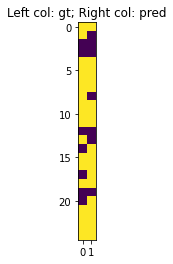

In [47]:
## VISUALIZE model output and parameters on test data

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())
    
    
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))

        
predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

plt.imshow(viz)
plt.title("Left col: gt; Right col: pred")

err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
err_perc



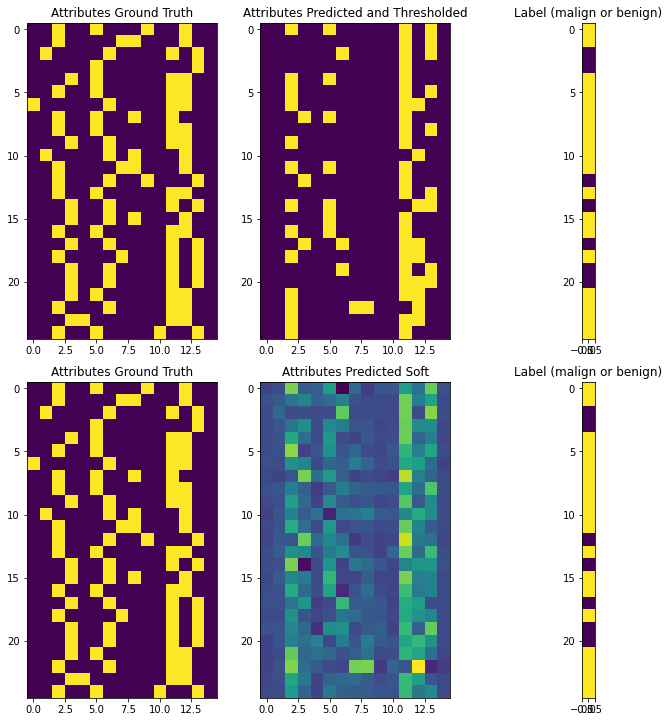

In [55]:
## ALL this should be on TEST set
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(np.expand_dims(viz[:, 0], 1))
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(np.expand_dims(viz[:, 0], 1))
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

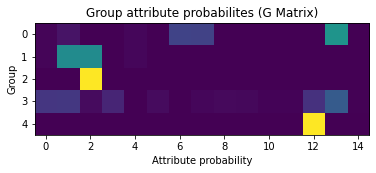

In [31]:
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")